In [47]:
# Reload modules
import importlib
import data_loader
importlib.reload(data_loader)
from data_loader import load_data, preprocess_data, load_sample_data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from data_loader import load_sample_data, preprocess_data

# Load sample data
stations_info, status_data = load_sample_data()
merged_data = preprocess_data(stations_info, status_data)

# Display basic statistics
print(merged_data.describe())

INFO:data_loader:Successfully connected to MongoDB
INFO:data_loader:Loaded 516 stations
INFO:data_loader:Attempting to load status data for September 2024
INFO:data_loader:Loaded 4424667 status records
INFO:data_loader:Successfully loaded data for September 2024
INFO:data_loader:Starting data preprocessing
INFO:data_loader:Merged data shape: (4424667, 12)
INFO:data_loader:Data shape after filtering non-existent stations: (4424667, 12)
INFO:data_loader:Data preprocessing completed


         station_id  num_bikes_available  num_docks_available  \
count  4.424667e+06         4.424667e+06         4.424667e+06   
mean   2.655210e+02         1.041275e+01         1.525376e+01   
min    1.000000e+00         0.000000e+00         0.000000e+00   
25%    1.350000e+02         3.000000e+00         8.000000e+00   
50%    2.660000e+02         8.000000e+00         1.600000e+01   
75%    3.950000e+02         1.600000e+01         2.200000e+01   
max    5.430000e+02         1.980000e+02         9.900000e+01   
std    1.512070e+02         1.012694e+01         9.115089e+00   

                       last_reported      altitude           lat  \
count                        4424667  4.404476e+06  4.424667e+06   
mean   2024-09-16 00:03:25.161469696  3.576893e+01  4.139935e+01   
min              2024-09-01 00:00:34  2.000000e+00  4.134677e+01   
25%              2024-09-08 12:05:51  9.000000e+00  4.138337e+01   
50%              2024-09-15 23:58:28  2.500000e+01  4.139578e+01   
75%   

In [2]:
# Time-based Analysis
def plot_system_usage():
    daily_usage = merged_data.groupby('last_reported').agg({
        'num_bikes_available': 'mean',
        'num_docks_available': 'mean'
    }).reset_index()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=daily_usage['last_reported'], y=daily_usage['num_bikes_available'], name='Available Bikes'))
    fig.add_trace(go.Scatter(x=daily_usage['last_reported'], y=daily_usage['num_docks_available'], name='Available Docks'))
    fig.update_layout(title='Overall System Usage', xaxis_title='Date', yaxis_title='Average Number')
    fig.show()

plot_system_usage()

In [ ]:
# Heatmap for each station
def plot_station_heatmap(station_id):
    station_data = merged_data[merged_data['station_id'] == station_id]
    pivot_data = station_data.pivot_table(values='num_bikes_available', index='hour', columns='day_of_week', aggfunc='mean')
    
    fig = px.imshow(pivot_data, labels=dict(x="Day of Week", y="Hour of Day", color="Available Bikes"),
                    title=f"Average Bike Availability for Station {station_id}")
    fig.show()

# Create a dropdown for station selection
station_ids = merged_data['station_id'].unique()
station_dropdown = go.FigureWidget()
station_dropdown.update_layout(
    updatemenus=[go.layout.Updatemenu(
        buttons=[dict(label=str(station_id), method='update', args=[{'visible': [True]}]) for station_id in station_ids],
        direction="down",
        showactive=True,
    )]
)

# Plot heatmap for the first station
plot_station_heatmap(station_ids[0])

In [ ]:
# Function to update heatmap based on selected station
def update_heatmap(trace, points, selector):
    if points.point_inds:
        selected_station = station_ids[points.point_inds[0]]
        plot_station_heatmap(selected_station)

station_dropdown.data[0].on_click(update_heatmap)

# Weekly patterns
def plot_weekly_patterns():
    weekly_data = merged_data.groupby(['day_of_week', 'hour']).agg({
        'num_bikes_available': 'mean',
        'num_docks_available': 'mean'
    }).reset_index()
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Available Bikes', 'Available Docks'))
    
    for i, metric in enumerate(['num_bikes_available', 'num_docks_available']):
        heatmap = go.Heatmap(
            x=weekly_data['day_of_week'],
            y=weekly_data['hour'],
            z=weekly_data[metric],
            colorscale='YlGnBu'
        )
        fig.add_trace(heatmap, row=1, col=i+1)
    
    fig.update_layout(title='Weekly Patterns of Bike and Dock Availability')
    fig.show()

plot_weekly_patterns()

In [ ]:
# Impact of weekends and holidays
def plot_weekend_holiday_impact():
    impact_data = merged_data.groupby(['is_weekend', 'is_holiday']).agg({
        'num_bikes_available': 'mean',
        'num_docks_available': 'mean'
    }).reset_index()
    
    fig = px.bar(impact_data, x=['is_weekend', 'is_holiday'], y=['num_bikes_available', 'num_docks_available'],
                 barmode='group', title='Impact of Weekends and Holidays on Bike Availability')
    fig.show()

plot_weekend_holiday_impact()

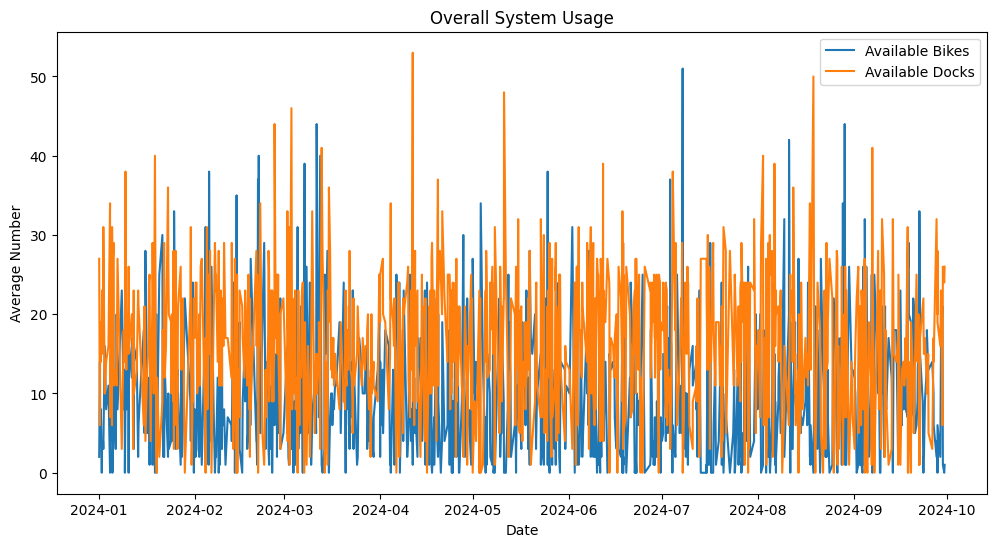

In [7]:
# Part 4: Overall System Usage
def plot_system_usage():
    daily_usage = merged_data.groupby('last_reported').agg({
        'num_bikes_available': 'mean',
        'num_docks_available': 'mean'
    })
    plt.figure(figsize=(12, 6))
    plt.plot(daily_usage.index, daily_usage['num_bikes_available'], label='Available Bikes')
    plt.plot(daily_usage.index, daily_usage['num_docks_available'], label='Available Docks')
    plt.title("Overall System Usage")
    plt.xlabel("Date")
    plt.ylabel("Average Number")
    plt.legend()
    plt.show()

# Example usage:
plot_system_usage()

In [12]:
# Part 5: Station Usage by Time of Day
def plot_station_usage_by_time(station_id):
    station_data = merged_data[merged_data['station_id'] == station_id]
    pivot_data = station_data.pivot_table(values='num_bikes_available', index='hour', aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=pivot_data, marker='o')
    plt.title(f"Average Bike Availability for Station {station_id} by Time of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Number of Available Bikes")
    plt.show()

